In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.random.set_seed(37)
np.random.seed(37)

from scipy.signal import detrend

In [2]:
home_dir = '/content/drive/MyDrive/Colab Notebooks/transient_detection/'

In [3]:
model = tf.keras.models.load_model(home_dir+'sequence_model_0.h5')

In [4]:
with open(home_dir+'vectorized_data.npy', 'rb') as fid:
    staname_vec = np.load(fid, allow_pickle=True)
    stalat_vec = np.load(fid, allow_pickle=True)
    stalon_vec = np.load(fid, allow_pickle=True)
    epoch_vec = np.load(fid, allow_pickle=True)
    disp_n_mat = np.load(fid, allow_pickle=True)
    disp_e_mat = np.load(fid, allow_pickle=True)
    disp_u_mat = np.load(fid, allow_pickle=True)
    rsi_prob_n_mat = np.abs(np.load(fid, allow_pickle=True))
    rsi_prob_e_mat = np.abs(np.load(fid, allow_pickle=True))
    rsi_prob_u_mat = np.abs(np.load(fid, allow_pickle=True))

In [5]:
n_sta = len(staname_vec)
n_epoch = len(epoch_vec)

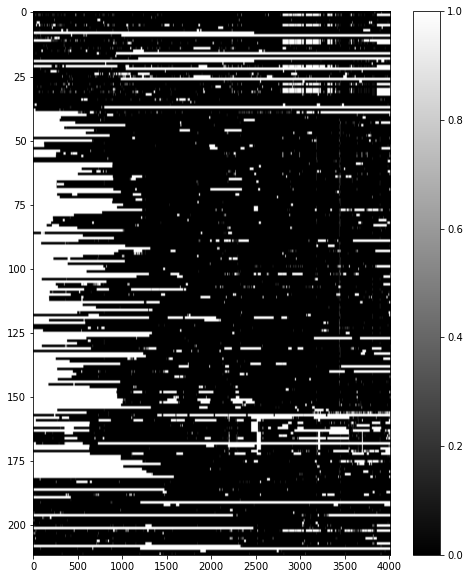

In [6]:
plt.figure(figsize=(8,10))
plt.imshow(np.int32(np.isnan(disp_n_mat)),aspect='auto',cmap=plt.cm.gray)
plt.colorbar()
plt.show()

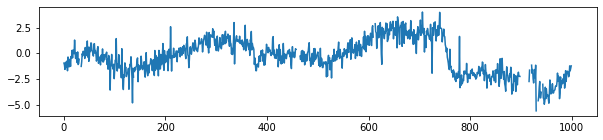

In [7]:
plt.figure(figsize=(10,2))
plt.plot(disp_e_mat[202,:1000])
plt.show()

In [8]:
a = np.random.rand(100)
a[-3:] = np.nan
np.nonzero(~np.isnan(a))[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

In [9]:
from sklearn.preprocessing import minmax_scale
def scale(data):
  return minmax_scale(detrend(data, axis=1), axis=1)

In [10]:
def predict_1sta(timeseries):
  
  d = timeseries.copy()
  prob = np.zeros(d.shape)

  d[np.isnan(d)] = 0

  valid_epochs = np.nonzero(d)[0]
  epoch_start = valid_epochs[0]
  epoch_end = valid_epochs[-1]

  d = scale(d[np.newaxis, epoch_start:epoch_end])

  valid_probs = np.squeeze(model.predict(d[:,:,np.newaxis]))
  prob[epoch_start:epoch_end] = valid_probs
  return prob

In [11]:
index_included = np.array([True for i in range(212)])
index_included[[16, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172]] = False

In [12]:
prob_n_mat = np.zeros((n_sta, n_epoch))
prob_e_mat = np.zeros((n_sta, n_epoch))
prob_u_mat = np.zeros((n_sta, n_epoch))

for i_sta in range(n_sta):
  if index_included[i_sta]: 
    prob_n_mat[i_sta,:] = predict_1sta(disp_n_mat[i_sta,:])
    prob_e_mat[i_sta,:] = predict_1sta(disp_e_mat[i_sta,:])
    prob_u_mat[i_sta,:] = predict_1sta(disp_u_mat[i_sta,:])

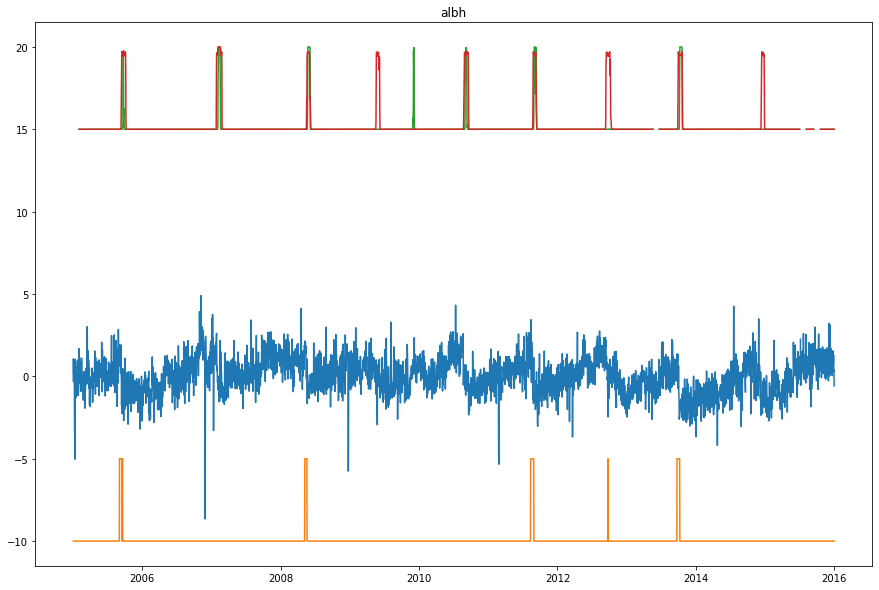

In [13]:
plt.figure(figsize=(15,10))
plt.plot(epoch_vec, np.squeeze(disp_n_mat[0,:]))
plt.plot(epoch_vec, 5*np.convolve(np.squeeze(prob_n_mat[0,:]>0.4), np.ones(1)/1, mode='same') -10)
plt.plot(epoch_vec, 5*np.squeeze(rsi_prob_n_mat[0,:]) + 15)
plt.plot(epoch_vec, 5*np.squeeze(rsi_prob_e_mat[0,:]) + 15)
plt.title(staname_vec[0])
#plt.xlim([2009, 2011])
plt.show()

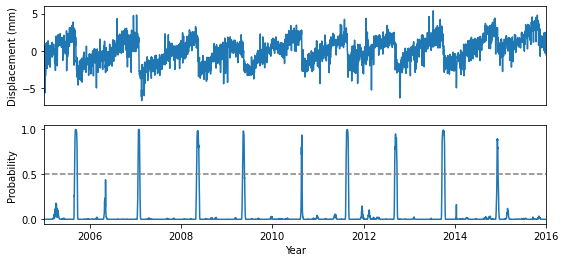

In [14]:
plt.figure(figsize=(9,4))
plt.subplot(2,1,1)
plt.plot(epoch_vec, disp_e_mat[0,:])
plt.xlim([2005, 2016])
plt.xticks([])
plt.ylabel('Displacement (mm)')

plt.subplot(2,1,2)
prob_e_mat[0,1:20] = 0
plt.plot(epoch_vec, prob_e_mat[0,:])
plt.xlim([2005, 2016])
plt.plot([2005,2016],[0.5,0.5],'--', color='gray')
plt.ylabel('Probability')
plt.xlabel('Year')
plt.savefig('albh.pdf', format='pdf',bbox_inches='tight', pad_inches=0.05)


In [57]:
epoch_mat, stalat_mat = np.meshgrid(epoch_vec, stalat_vec)
prob_mat = np.maximum(np.maximum(prob_e_mat, prob_n_mat), prob_u_mat)
prob_mat
#pred_mat = pred_e_mat

index_pos = prob_mat > 0.5
prob_vec_pos = prob_mat[index_pos]
epoch_vec_pos = epoch_mat[index_pos]
stalat_vec_pos = stalat_mat[index_pos]


index_sort = np.argsort(prob_vec_pos)
prob_vec_pos = prob_vec_pos[index_sort]
epoch_vec_pos = epoch_vec_pos[index_sort]
stalat_vec_pos = stalat_vec_pos[index_sort]

In [16]:
sns.set_style("ticks")
plt.rcParams['font.size'] = '12'

Text(0, 0.5, 'Latitude')

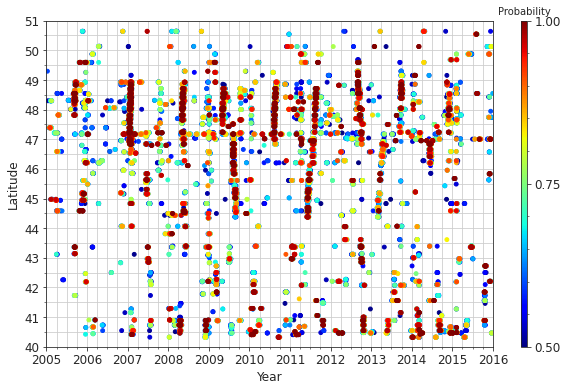

In [59]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(epoch_vec_pos, stalat_vec_pos, s=15, c=prob_vec_pos, cmap=plt.cm.jet)
cbar = plt.colorbar(aspect=50)
cbar.set_ticks([0.5, 0.75, 1.0])
cbar.minorticks_on()
cbar.ax.set_title('Probability', fontsize=10)
plt.clim(0.5, 1.0)
plt.xlim(2005, 2016)
plt.ylim(40, 51)
plt.xticks(np.arange(2005,2017))
plt.yticks(np.arange(40,52))
ax.set_yticks(np.arange(40,51,0.5), minor=True)
ax.set_xticks(np.arange(2005,2016,0.25), minor=True)
plt.grid(True, 'both', 'both')
plt.xlabel('Year')
plt.ylabel('Latitude')
#plt.savefig('ml_detection_result.pdf', format='pdf',bbox_inches='tight', pad_inches=0.05)

Export results

In [18]:
# export to a file that is good for remodeler.mat
for i_sta in range(n_sta):
  sta_result = np.zeros((n_epoch, 14))

  sta_result[:, 0] = epoch_vec

  sta_result[:, 3] = disp_n_mat[i_sta, :]
  sta_result[:, 4] = disp_e_mat[i_sta, :]
  sta_result[:, 5] = disp_u_mat[i_sta, :]

  sta_result[:, 9 ] = prob_n_mat[i_sta,:]
  sta_result[:, 10] = prob_e_mat[i_sta,:]
  sta_result[:, 11] = prob_u_mat[i_sta,:]

  index = np.logical_and(~np.isnan(sta_result[:, 3]), ~np.isnan(sta_result[:, 9]))

  sta_result = sta_result[index, :]
  
  np.savetxt(home_dir+'ml_rawresults/'+staname_vec[i_sta]+'.txt', sta_result, fmt='%.4f')

KeyboardInterrupt: ignored